In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

## CartPole-v0 환경을 이용, 폴이 안쓰러지게 학습
env = gym.make('CartPole-v0').unwrapped


'''
# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
'''

plt.ion()

In [2]:
## Training 중인 상태를 plot으로 표현




def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    plt.axhline(y=200,linestyle ='--')
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤

In [3]:
## Testing에서 사용
def plot_durations1():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(results, dtype=torch.float)
    plt.title('Test')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    plt.axhline(y=200,linestyle ='--')
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    

In [4]:
## Experience Replay
## 학습에 이용할 메모리
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        self.position = (self.position + 1) % self.capacity
        if len(self.memory) >= self.capacity: 
            self.memory[self.position] = transition

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
## 큰 차원의 데이터를 다루기위해서 사용

'''4개의 Q 값을 도출해내는 Network 구조를 가짐'''
## 학습에 쓰이는  NN 
## Input은 State가 되고 Output은 Q - value가 된다.
class DQN(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2,action_size)
        self.fc4 = nn.Linear(hidden_size*2,action_size)
        self.fc5 = nn.Linear(hidden_size*2,action_size)
        self.fc6 = nn.Linear(hidden_size*2,action_size)
        
    ## 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됨.
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x1 = self.fc3(x)
        x2 = self.fc4(x)
        x3 = self.fc5(x)
        x4 = self.fc6(x)
        return x1,x2,x3,x4

In [6]:
## Hyperparameters
'''OFFLINE 학습 방법에서는 Exploration을 최대한 다양하게 해야된다'''
BATCH_SIZE = 30
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.5
EPS_DECAY = 400
TARGET_UPDATE = 10
num_episodes = 1000
hidden_size = 50
tau = 0.1

train_num = 20000

## 메모리 크기 / Offline Learning이기 때문에 메모리의 크기가 크다.
memory = ReplayMemory(1000000)

## gym 행동 공간에서 행동의 숫자를 얻기.
input_size = env.observation_space.shape[0]
n_actions = env.action_space.n

## 큰 차원의 데이터를 처리하기 위해서 NN을 사용
policy_net = DQN(input_size,hidden_size, n_actions)
target_net = DQN(input_size,hidden_size, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

## 최적화 기준 RMS(Root Mean Squeare)
optimizer = optim.RMSprop(policy_net.parameters(), lr =0.001)

## 몇번의 스탭을 했는지.
steps_done = 0

In [7]:
## Google 논문에 있는 Action Select 방식
def select_mean_action(state):
    act1,act2,act3,act4 = policy_net(Variable(state))
    act1 = torch.FloatTensor(act1)
    act2 = torch.FloatTensor(act2)
    act3 = torch.FloatTensor(act3)
    act4 = torch.FloatTensor(act4)
    action = (act1 + act2 + act3 + act4) /4 

    return action.data.max(1)[1].view(1,1)

In [9]:
'''Action을 하는 Q 값을 랜덤으로 설정하기 위한변수'''
 random_q = [1,2,3,4]

'''e보다 큰 값을 통해서 Action을 선택할 때 오직 하나의 Q Value만을 이용해서 선택하는 방법을 이용'''
## e- greedy를 이용한 Action 선택
def select_action(state):
    global steps_done
    ## 0과1사이의 값을 무작위로 가져옴
    sample = random.random()
    ## Epsilon-Threshold의 값이 step이 반복될 수록 작아진다.
    ## 점점 greedy action을 택하게 만듬.
    steps_done += 1
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
    math.exp(-1. * (steps_done) / EPS_DECAY)
    if sample > eps_threshold :
        with torch.no_grad():
            """
            t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            기대 보상이 더 큰 행동을 선택할 수 있습니다.
            """
            '''4개의 Q 값 중 랜덤하게 하나를 선택하는 구조'''
            
            
            """
            act1,act2,act3,act4 = policy_net(Variable(state))
            sample_num = random.choice(random_q)
            if sample_num == 1 :
                action = torch.FloatTensor(act1).data.max(1)[1].view(1,1)
            elif sample_num == 2:
                action = torch.FloatTensor(act2).data.max(1)[1].view(1,1)
            elif sample_num == 3 :
                action = torch.FloatTensor(act3).data.max(1)[1].view(1,1)
            else :
                action = torch.FloatTensor(act4).data.max(1)[1].view(1,1)
            """
            '''
            ## Deterministic하게 선택하는 구조
            act,_,_,_ = policy_net(Variable(state))
            action = torch.FloatTensor(act).data.max(1)[1].view(1,1)
            '''
            '''Select Action by mean of Q values'''
            action = select_mean_action(state)
            
            return action
        # Random action 선택
    else:
        return torch.LongTensor([[random.randrange(n_actions)]])

In [10]:
'''Test 할때 사용되는 방법으로 Majority Action을 찾는다. 4개의 Q Value가 투표형식으로 Action을 선택한다.'''
def select_majority_action(act1,act2,act3,act4):
    ## Majority Vote
    action1 = torch.FloatTensor(act1).data.max(1)[1].view(1,1)
    action2 = torch.FloatTensor(act2).data.max(1)[1].view(1,1)
    action3 = torch.FloatTensor(act3).data.max(1)[1].view(1,1)
    action4 = torch.FloatTensor(act4).data.max(1)[1].view(1,1)
    ## Cartpole의 Action Dim = 2 (0,1) 이므로 2가지만 생각함.
    count_zero = 0
    if action1 == 0 :
        count_zero += 1
    if action2 == 0 :
        count_zero += 1
    if action3 == 0 :
        count_zero += 1
    if action4 == 0 :
        count_zero += 1

    if count_zero >= 2 :
        action = 0
    else :
        action = 1
    return action

In [11]:
## Loss 계산을 위한 함수
def dqn_loss(q_val,next_q_val,gamma,reward,is_done) :
    ex_q = reward + gamma * next_q_val * (1-is_done)
    loss = F.smooth_l1_loss(q_val,ex_q.unsqueeze(1))
    return loss

def ddqn_loss(q_val,pol_next_q, targ_next_q, gamma, reward, is_done):
    next_q = targ_next_q.gather(1,torch.max(pol_next_q,1)[1].unsqueeze(1)).squeeze(1)
    ex_q = reward + gamma * next_q * (1-is_done)
    loss = F.smooth_l1_loss(q_val.squeeze(),ex_q)
    return loss

In [12]:
## Optimize
'''총 4개의 Q Value로 나온 Q Value의 평균을 이용해서 LOSS 구하기'''
'''LOSS는 DQN으로 나옴'''
'''Random 한 Coeffiecent 를 통해서 Q _ Value의 가중치를 다르게 곱하는 방식이다.'''
def optimize_model_REM():
        if len(memory) < BATCH_SIZE:
            return
        ## Memory에서 Sample을 가져옴    
        transitions = memory.sample(BATCH_SIZE)


        state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*transitions)


        state_batch =torch.cat(state_batch)
        next_state_batch = Variable(torch.cat(next_state_batch))
        action_batch = Variable(torch.cat(action_batch))
        reward_batch = Variable(torch.cat(reward_batch))
        done_batch = Variable(torch.cat(done_batch))


        '''Optimize 하는 부분 / /
        DQN Loss를 계산함.'''
        
        ## Random Coeffiecient
        coef = np.random.random(q_num)
        ## coef 의 합을 1로 만듬
        coef = coef / sum(coef)

        ## 공통적으로 사용하는 Q - Value
        state_action_values1,state_action_values2,\
        state_action_values3,state_action_values4 = policy_net(state_batch)
        
        q_value_sum = (coef[0] * state_action_values1 + coef[1] * state_action_values2 \
                       + coef[2] * state_action_values3 + coef[3] * state_action_values4)
        
        state_action_values_sum = q_value_sum.gather(1, action_batch)
   
        
        next_state_action_values1,next_state_action_values2,next_state_action_values3,\
        next_state_action_values4 = policy_net(next_state_batch)
        
        next_state_action_values = (coef[0] * next_state_action_values1 + coef[1] * next_state_action_values2 \
                                          + coef[2] * next_state_action_values3 + coef[3] * next_state_action_values4)
        
        '''DQN 계산하는 부분'''
        
        ## DQN Loss 계산
        
        next_state_action_values_sum = next_state_action_values.max(1)[0]
    
        '''평균 Q Value'''
        ## 기대 Q 값 계산 
        ## Huber 손실 계산 / L1 loss
        dqnloss = dqn_loss(state_action_values_sum,next_state_action_values_sum,GAMMA,reward_batch,done_batch)
        
       
        loss = dqnloss

        ## 모델 최적화
        optimizer.zero_grad()
        loss.backward()
        for param in policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

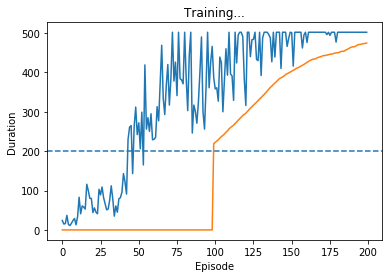

Complete


<All keys matched successfully>

In [13]:
## 폴이 쓰러지면 한번에 에피소드가 종료
## Training Section
## 이 부분을 여러번 돌리면 학습을 여러번 한 효과

for i_episode in range(num_episodes):
    ## 환경과 상태 초기화
    state = env.reset()
    
    ## 현재 상태를 지정
    for t in count():
        ## 행동 선택과 수행
        state = torch.FloatTensor([state])
        
        action = select_action(state)
        
        next_state, reward, done, _ = env.step(action)
               
        if done : 
            reward = -100
        ## 메모리에 변이 저장(한번에 에피소드에 많은 메모리가 생김)
        memory.push((state,action, torch.FloatTensor([next_state]), \
                    torch.FloatTensor([reward]), torch.FloatTensor([done])))

        if done or t > 500:
            episode_durations.append(t + 1)
            break 
        
        
        ## 다음 상태로 이동
        state = next_state
        
        ## 최적화 한단계 수행(Policy 네트워크에서)
        optimize_model_REM()

        
    ## Policy 네트워크 업데이트, 모든 웨이트와 바이어스 복사 => Target으로
    ## Target_update 기준으로 몇번에 한번씩 업데이트 할 것인지 결정
    if i_episode % TARGET_UPDATE == 0:
        for param, target_param in zip(policy_net.parameters(),target_net.parameters()):
                target_param.data.copy_(tau * param.data + (1-tau) * target_param.data)
    ## Output을 계속 볼수 있게
    if i_episode % 200 ==0:
        plot_durations()
    
    if i_episode % 500 == 0:
        clear_output()
    
    
plot_durations()

print('Complete')

plt.ioff()
plt.show()



target_net.load_state_dict(policy_net.state_dict())

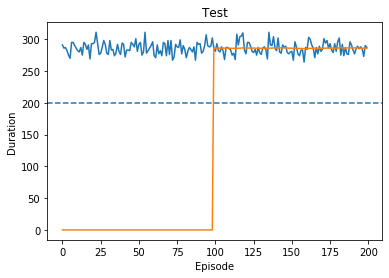

Complete


In [15]:
## Testing Section
results = []
num_episode =200
i_episode = 0
for i_episode in range(num_episode):
    ## 환경과 상태 초기화
    state = env.reset()

    ## 에피소드 시작
    for t in count():
        ## 행동 선택과 수행 / Test하는 과정이므로 학습된 네트워크가 행동 결정
        state = torch.FloatTensor([state]) 
        
        act1,act2,act3,act4 = target_net(Variable(state))
        
        action = select_majority_action(act1,act2,act3,act4)
        
        next_state, reward, done, _ = env.step(action)
        

        if done or t > 500:
            results.append(t + 1)
            break 

        ## 다음 상태로 이동
        state = next_state

plot_durations
plot_durations1()
print('Complete')


plt.ioff()
plt.show()